In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [ ]:
# LOAD DATA
from google.colab import files


uploaded = files.upload()

Saving ecommerce_furniture_dataset_2024.csv to ecommerce_furniture_dataset_2024 (1).csv


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['ecommerce_furniture_dataset_2024 (1).csv']))

In [ ]:
print(df.head())

                                        productTitle originalPrice    price  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...           NaN   $46.79   
1  Outdoor Conversation Set 4 Pieces Patio Furnit...           NaN  $169.72   
2  Desser For Bedroom With 7 Fabric Drawers Organ...         $78.4   $39.46   
3  Modern Accent Boucle Chair,Upholstered Tufted ...           NaN  $111.99   
4  Small Unit Simple Computer Desk Household Wood...        $48.82   $21.37   

   sold        tagText  
0   600  Free shipping  
1     0  Free shipping  
2     7  Free shipping  
3     0  Free shipping  
4     1  Free shipping  


#DATA CLEANING

In [ ]:
#    DATA CLEANING
print("\nBefore Cleaning (Data Types):")
print(df.dtypes)


Before Cleaning (Data Types):
productTitle     object
originalPrice    object
price            object
sold              int64
tagText          object
dtype: object


In [ ]:
# Strip spaces from object columns
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

# Convert prices and sold to numeric
for col in ['originalPrice', 'price', 'sold']:
    if col in df.columns:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(r'[\$,]', '', regex=True),
            errors='coerce'
        )


In [ ]:
# Derived columns
df['discount_pct'] = ((df['originalPrice'] - df['price']) / df['originalPrice'] * 100).round(2)
df['revenue'] = df['price'] * df['sold']


print("\nAfter Cleaning (Sample Data):")
print(df.head())


After Cleaning (Sample Data):
                                        productTitle  originalPrice   price  \
0  Dresser For Bedroom With 9 Fabric Drawers Ward...            NaN   46.79   
1  Outdoor Conversation Set 4 Pieces Patio Furnit...            NaN  169.72   
2  Desser For Bedroom With 7 Fabric Drawers Organ...          78.40   39.46   
3  Modern Accent Boucle Chair,Upholstered Tufted ...            NaN  111.99   
4  Small Unit Simple Computer Desk Household Wood...          48.82   21.37   

   sold        tagText  discount_pct   revenue  
0   600  Free shipping           NaN  28074.00  
1     0  Free shipping           NaN      0.00  
2     7  Free shipping         49.67    276.22  
3     0  Free shipping           NaN      0.00  
4     1  Free shipping         56.23     21.37  


In [ ]:
print("\nData Summary:")
print(df.describe(include='all'))


Data Summary:
                                             productTitle  originalPrice  \
count                                                2000     487.000000   
unique                                               1793            NaN   
top     3 Pieces Rocking Wicker Bistro Set, Patio Outd...            NaN   
freq                                                    6            NaN   
mean                                                  NaN     256.028090   
std                                                   NaN     422.737861   
min                                                   NaN       3.630000   
25%                                                   NaN      31.770000   
50%                                                   NaN      88.310000   
75%                                                   NaN     314.125000   
max                                                   NaN    3265.130000   

              price          sold        tagText  discount_pct        re

# EXPLORATORY DATA ANALYSIS

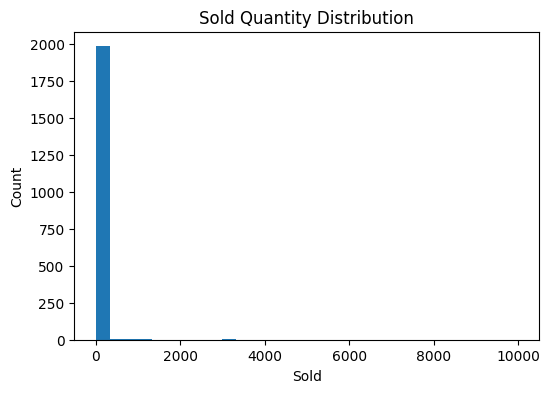

In [ ]:

# Sold distribution
plt.figure(figsize=(6,4))
plt.hist(df['sold'].dropna(), bins=30)
plt.title('Sold Quantity Distribution')
plt.xlabel('Sold')
plt.ylabel('Count')
plt.show()

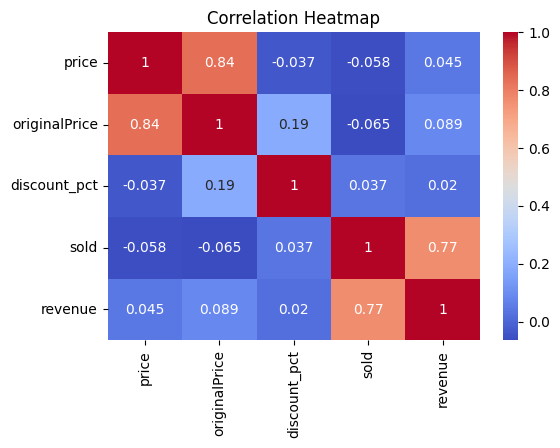

In [ ]:
# Correlation heatmap
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(df[['price', 'originalPrice', 'discount_pct', 'sold', 'revenue']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

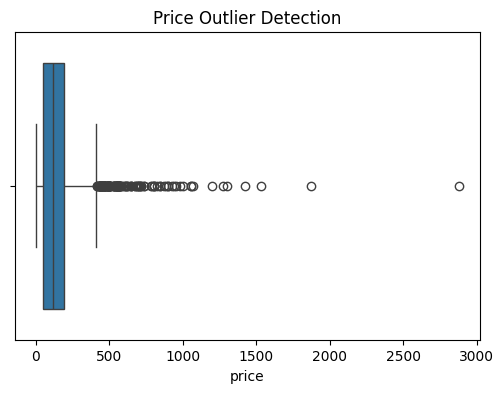

In [ ]:
# Outlier check
plt.figure(figsize=(6,4))
sns.boxplot(x=df['price'])
plt.title('Price Outlier Detection')
plt.show()

# DESCRIPTIVE STATISTICS


In [ ]:
print("Total items sold:", df['sold'].sum())

Total items sold: 46987


In [ ]:
print("Total revenue:", df['revenue'].sum())

Total revenue: 2181048.07


In [ ]:
print("Average order value (AOV):", df['revenue'].mean())

Average order value (AOV): 1090.524035


In [ ]:
print("Median price:", df['price'].median())

Median price: 114.08


In [ ]:
print("Max price:", df['price'].max())

Max price: 2876.38


In [ ]:
print("Min price:", df['price'].min())

Min price: 0.99


# PRICE DISTRIBUTION

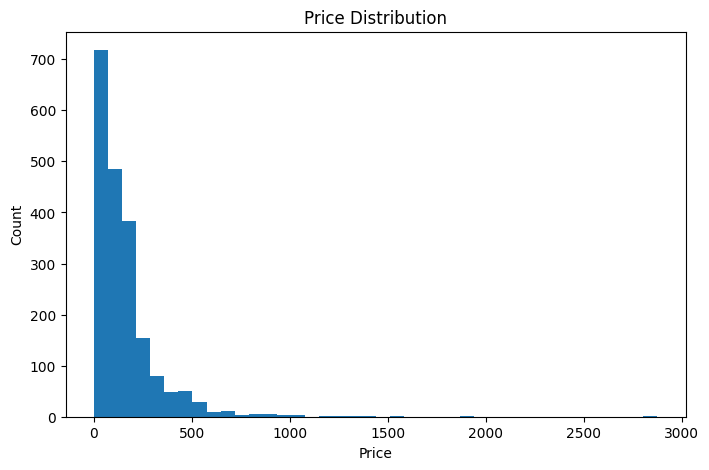

In [ ]:
#Price Distribution
plt.figure(figsize=(8,5))
plt.hist(df['price'].dropna(), bins=40)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# DISCOUNT IMPACT ANALYSIS

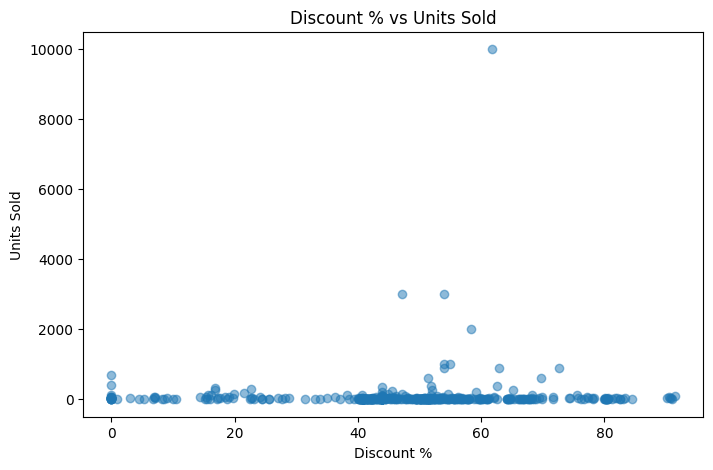

In [ ]:
#Discount % vs Units Sold
plt.figure(figsize=(8,5))
plt.scatter(df['discount_pct'], df['sold'], alpha=0.5)
plt.title('Discount % vs Units Sold')
plt.xlabel('Discount %')
plt.ylabel('Units Sold')
plt.show()


In [ ]:
print("\nCorrelation between discount % and units sold:", df[['discount_pct','sold']].corr().iloc[0,1])


Correlation between discount % and units sold: 0.03708519945251183


# PRICE SENSITIVITY(BANDS)

In [ ]:
max_price = df['price'].dropna().max()
if max_price <= 5000:
    max_price = 5001

In [ ]:
price_bins = [0, 100, 500, 1000, 5000, max_price]
labels = ['Low(<100)','Budget(100-500)','Mid(500-1000)','High(1000-5000)','Premium(5000+)']

df['price_band'] = pd.cut(df['price'], bins=price_bins, labels=labels, include_lowest=True)

In [ ]:
band_summary = df.groupby('price_band').agg({
'sold':'sum','revenue':'sum','price':'mean'
}).sort_values('revenue', ascending=False)
print("\nPrice Band Analysis:")
print(band_summary)


Price Band Analysis:
                  sold     revenue        price
price_band                                     
Budget(100-500)   5234  1003348.42   206.162214
Low(<100)        41499   990308.94    45.636592
Mid(500-1000)      219   142780.97   657.038000
High(1000-5000)     35    44609.74  1423.100000
Premium(5000+)       0        0.00          NaN


/tmp/ipython-input-2841801374.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_summary = df.groupby('price_band').agg({


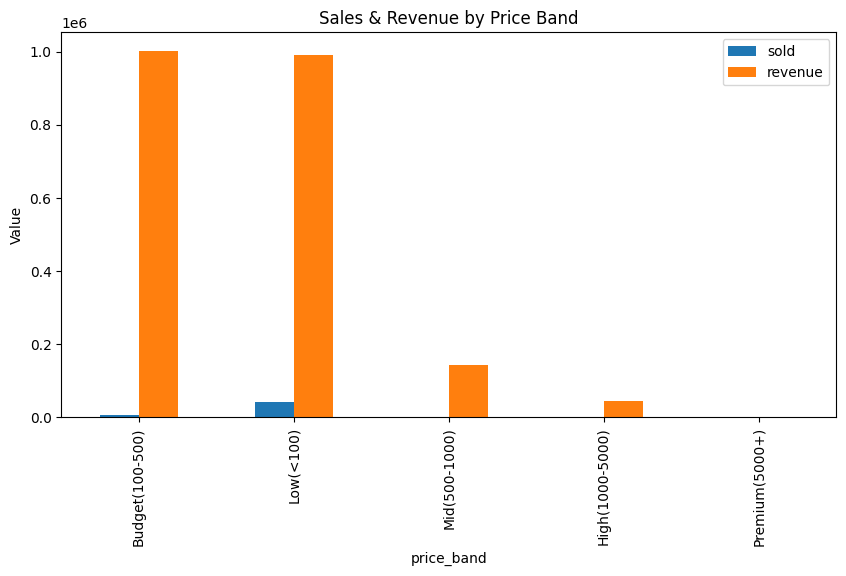

In [ ]:
#Sales & Revenue by Price Band
band_summary[['sold','revenue']].plot(kind='bar', figsize=(10,5))
plt.title('Sales & Revenue by Price Band')
plt.ylabel('Value')
plt.show()

# PRODUCT PERFORMANCE

In [ ]:
print("\nTop 10 Products by Units Sold:")
print(df.groupby('productTitle')['sold'].sum().sort_values(ascending=False).head(10))


Top 10 Products by Units Sold:
productTitle
Portable round Folding Chair Accordion Chair Height Adjustment Simple Tool Elephant Swing Playground Queue Chair                   10000
MUMUCC Multifunctional Foldable And Adjustable Aluminum Alloy Reading Stand With Spring Clip For Laptops, Tablets & Thick Books     6000
Stylish Shoe Rack Metal Simple Shoe Shelf Footwear Organizer Stand Holder Space-saving Black Shoe Shelf for Living Room             2000
Portability Foot Rest Under Desk Footrest Ergonomic Foot Stool with Massage Rollers Foot Rest for Home Office Work Fast Ship        1900
Office Furniture Computer Stand 42*26cm Adjustable Foldable Laptop Holder Notebook Desks Lap PC Folding Desk Table Vented Stand     1000
Portable Folding Telescopic Stool Lightweight Plastic Subway Queuing Chair Outdoor Camping Chair Fishing Seat with Carry Bag         900
Monitor Stand for 13-32 inches Screens, Dual Monitor Mount Gas Spring, Dual Monitor Arm Full Motion Adjustable                       

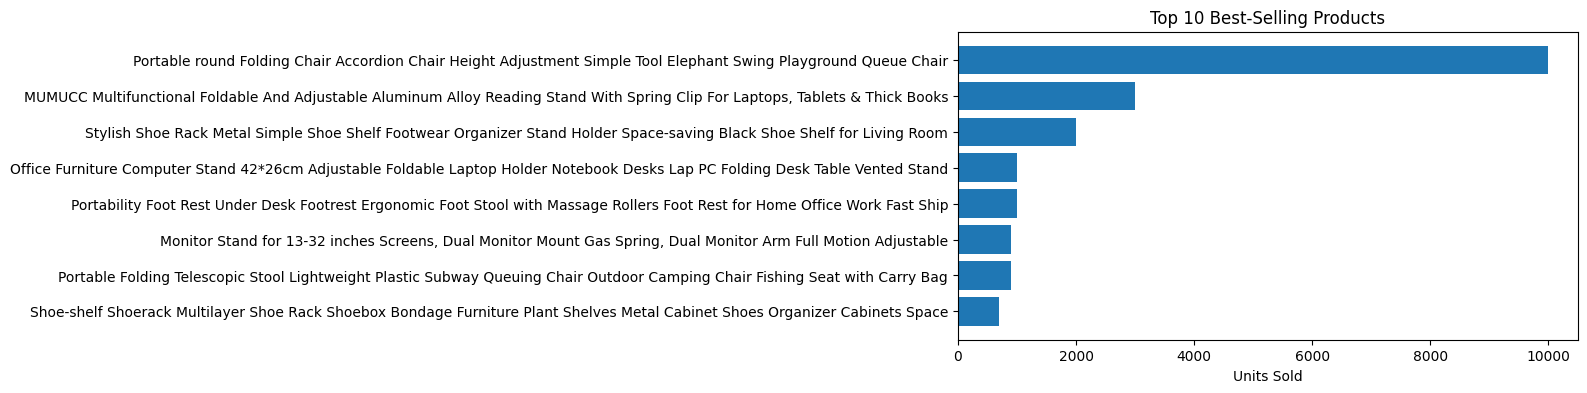

In [ ]:
# Top-selling products
top_selling = df.sort_values('sold', ascending=False).head(10)
plt.figure(figsize=(8,4))
plt.barh(top_selling['productTitle'], top_selling['sold'])
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Units Sold')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
print("\nTop 10 Products by Revenue:")
print(df.groupby('productTitle')['revenue'].sum().sort_values(ascending=False).head(10))


Top 10 Products by Revenue:
productTitle
MUMUCC Multifunctional Foldable And Adjustable Aluminum Alloy Reading Stand With Spring Clip For Laptops, Tablets & Thick Books    144150.00
Portable round Folding Chair Accordion Chair Height Adjustment Simple Tool Elephant Swing Playground Queue Chair                   122800.00
Caterpillar Single Sofa Lazy Couch Tatami Living Room Bedroom Lovely Leisure Single Chair Reading Chair Balcony Rocking Chair      101288.75
Monitor Stand for 13-32 inches Screens, Dual Monitor Mount Gas Spring, Dual Monitor Arm Full Motion Adjustable                      60012.00
Electric Stand Up Desk Workstation Whole-Piece Desktop Ergonomic Height Adjustable Standing Desk With Cup and headphone holder      54055.80
MINGDIBAO Fabric Sofa Set Furniture Living Room Sofa Set with USB and Stools / Big U Shape Cloth Couch Sofas for Home Furniture     31853.75
Dresser For Bedroom With 9 Fabric Drawers Wardrobe Steel Frame Assembly Closet For Clothes Storage Display Cabin

# CATEGORY / TAG ANALYSIS

In [ ]:
if 'tagText' in df.columns:
    tag_summary = df.groupby('tagText').agg({
        'sold': 'sum',
        'revenue': 'sum',
        'discount_pct': 'mean',
        'price': 'mean'
    }).sort_values('revenue', ascending=False)

    print("\nCategory/Tag Analysis (Top 10):")
    print(tag_summary.head(10))



Category/Tag Analysis (Top 10):
                     sold     revenue  discount_pct       price
tagText                                                        
Free shipping       44452  2006829.54     47.236969  163.940809
+Shipping: $109.18    405    94551.30           NaN  233.460000
+Shipping: $2.91      166     8069.45      5.250000   38.915000
+Shipping: $225.12    118     6743.70     75.570000   57.150000
+Shipping: $132.48     58     6678.70           NaN  115.150000
+Shipping: $5.09      284     6344.62           NaN   19.633333
+Shipping: $12.03      53     5021.75           NaN   94.750000
+Shipping: $168.91    150     4879.50           NaN   32.530000
+Shipping: $363.95     37     3298.55           NaN   89.150000
+Shipping: $76.6       53     2434.82           NaN   45.940000


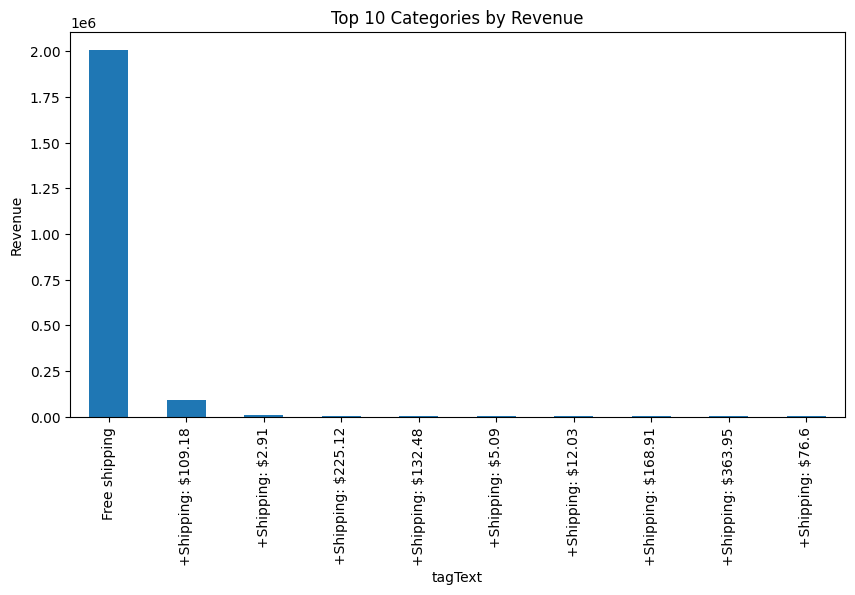

In [ ]:
#Top 10 Categories by Revenue
tag_summary['revenue'].head(10).plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Categories by Revenue')
plt.ylabel('Revenue')
plt.show()

# DEAD STOCK & STAR PRODUCTS

In [ ]:
low_sales_high_discount = df[(df['discount_pct'] > 30) & (df['sold'] < df['sold'].median())]
print("\nProducts with High Discount but Low Sales (Dead Stock):")
print(low_sales_high_discount[['productTitle','price','discount_pct','sold']].head(10))



Products with High Discount but Low Sales (Dead Stock):
                                          productTitle   price  discount_pct  \
4    Small Unit Simple Computer Desk Household Wood...   21.37         56.23   
28   Modern Small Bedside Table with Drawer Lock No...   49.39         50.01   
37   Simple Wardrobe Portable Large Capacity Assemb...   40.13         51.22   
60   Makeup Table With 5 Drawers & Shelves Vanity T...  175.94         43.91   
74   Living Room Sofa Set , L Shape Modular Storage...  584.05         40.61   
84   Modern Small Bedside Table with Drawer Lock No...   49.39         50.01   
106  Simple Wardrobe Portable Large Capacity Assemb...   40.13         51.22   
154  1: 12 Miniature Wooden Furniture: Wood Cabinet...    1.99         55.68   
182  3 Pieces Rocking Wicker Bistro Set, Patio Outd...  100.34         66.98   
199  Nordic Coffee Table Luxury Bed Side Table Pers...   61.61         43.93   

     sold  
4       1  
28      1  
37      1  
60      1  
74

In [ ]:
star_products = df[(df['discount_pct'] < 10) & (df['sold'] > df['sold'].median())]
print("\nStar Products (Low Discount, High Sales):")
print(star_products[['productTitle','price','discount_pct','sold']].head(10))


Star Products (Low Discount, High Sales):
                                          productTitle   price  discount_pct  \
284  Nordic Style Inflatable Transparent Sofa Lazy ...   38.01          0.00   
326  Patio Furniture Sets, 7 Piece PE Rattan Wicker...  673.94          0.88   
335  New Lazy Inflatable Sofa Chairs Large Tatami P...   27.17          0.00   
382  2/3/4/5 layer Nordic Round Bedside Table Mini ...   53.40          0.00   
458  Home Furniture Women's Luxury Belt Vip Luxury ...   10.29          0.00   
494  Shoe-shelf Shoerack Multilayer Shoe Rack Shoeb...   15.40          0.00   
512  Organization and Storage Shelves Nordic Furnit...   34.02          6.85   
539  Bamboo Shoe Cabinet Shoes Organizers Plastic S...   34.41          0.00   
548  Plastic Space Saving Shoe Rack Bamboo Shoe Cab...   31.24          0.00   
552  Small Home Furniture End Tables Decor The Side...   18.37          0.00   

     sold  
284    55  
326    17  
335    31  
382    21  
458    68  
494 

# REGRESSION MODEL (Predict Sales)

In [ ]:
X = df[['price','discount_pct']].fillna(0)
y = df['sold'].fillna(0)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
print("\nRegression Coefficients:", dict(zip(X.columns, model.coef_)))
print("Intercept:", model.intercept_)
print("R² Score (Test):", model.score(X_test, y_test))


Regression Coefficients: {'price': np.float64(-0.0628165570397991), 'discount_pct': np.float64(1.4773699747812428)}
Intercept: 17.94121846024788
R² Score (Test): 0.011231461676627807


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate the model
print("\nLinear Regression Results:")
print(f"R^2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")



Linear Regression Results:
R^2 Score: 0.011
RMSE: 73.634


# REGRESSION VISUALIZATIONS

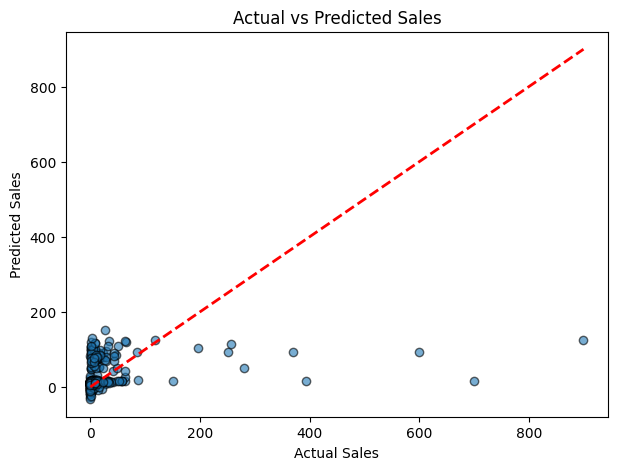

In [ ]:
#Actual vs Predicted Sales
y_pred = model.predict(X_test)


plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.show()

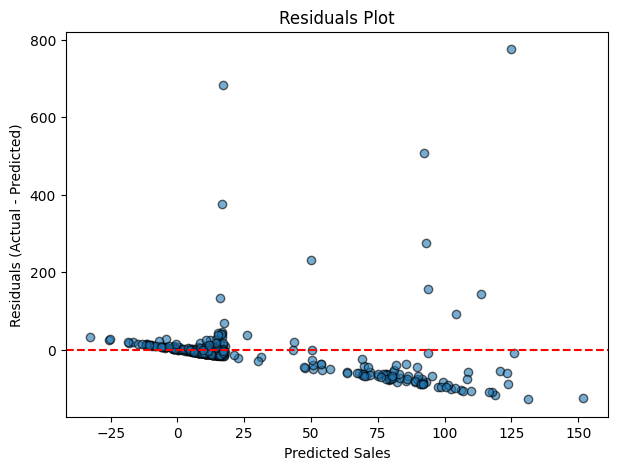

In [ ]:
#Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

# PARETO ANALYSIS (80/20 RULE)

In [ ]:
df_sorted = df.sort_values('revenue', ascending=False)
df_sorted['cum_revenue'] = df_sorted['revenue'].cumsum()
df_sorted['cum_revenue_pct'] = df_sorted['cum_revenue'] / df_sorted['revenue'].sum() * 100


print("\nPareto Summary (Top 5):")
print(df_sorted[['productTitle','revenue','cum_revenue_pct']].head())


Pareto Summary (Top 5):
                                           productTitle   revenue  \
1008  Portable round Folding Chair Accordion Chair H...  122800.0   
863   Caterpillar Single Sofa Lazy Couch Tatami Livi...   94551.3   
696   MUMUCC Multifunctional Foldable And Adjustable...   78330.0   
1391  MUMUCC Multifunctional Foldable And Adjustable...   65820.0   
1016  Monitor Stand for 13-32 inches Screens, Dual M...   60012.0   

      cum_revenue_pct  
1008         5.630321  
863          9.965452  
696         13.556845  
1391        16.574660  
1016        19.326181  


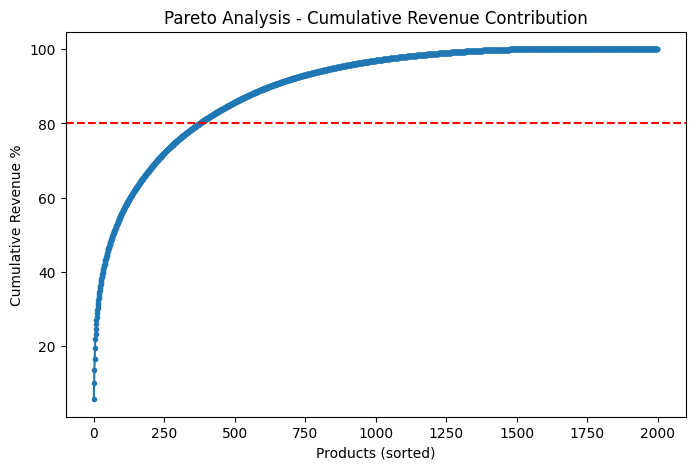

In [ ]:
#Pareto Analysis
plt.figure(figsize=(8,5))
plt.plot(range(len(df_sorted)), df_sorted['cum_revenue_pct'], marker='.')
plt.axhline(y=80, color='r', linestyle='--')
plt.title('Pareto Analysis - Cumulative Revenue Contribution')
plt.xlabel('Products (sorted)')
plt.ylabel('Cumulative Revenue %')
plt.show()